In [52]:
import openmc
import numpy as np
import neutronics_material_maker as nmm
import matplotlib.pyplot as plt
from cycler import cycler
from math import cos, pi

In [53]:
import openmc_source_plotter

In [54]:
#materials
#air
air = openmc.Material(name='air')
air.add_element("O",0.210748,'ao')
air.add_element("N",0.784431,'ao')
air.add_element("Ar",0.004671,'ao')
air.add_element("C", 0.00015,'ao')
air.set_density("g/cm3", 0.001205)

#ground surface - concrete
#ground_material = nmm.Material.from_library("concrete_heavy").openmc_material
ground_material = openmc.Material(name='ground_material')
ground_material.add_element("H" , 0.0052, 'ao')
ground_material.add_element("O",  0.3273, 'ao')
ground_material.add_element("C", 0.004, 'ao')
ground_material.add_element("Si", 0.0224, 'ao')
ground_material.add_element("Ca",  0.0657, 'ao')
ground_material.add_element("Mg", 0.0021, 'ao')
ground_material.add_element("Al", 0.0038, 'ao')
ground_material.add_element("Fe", 0.568, 'ao')
ground_material.add_element("P", 0.0015, 'ao')
ground_material.set_density("g/cm3", 3.6)
mats = openmc.Materials([ground_material, air])
mats.export_to_xml()

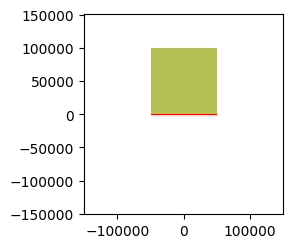

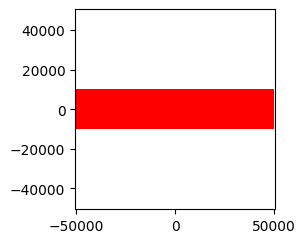

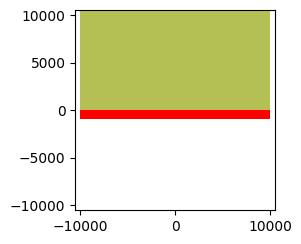

In [55]:
#ground surface
air_surface = openmc.model.RectangularParallelepiped(-50000, 50000, -10000, 10000, 0, 100000)
air_cell = openmc.Cell(region=-air_surface, fill=air)

ground_surface = openmc.model.RectangularParallelepiped(-50000, 50000, -10000, 10000, -1000, 0)
ground_cell = openmc.Cell(region=-ground_surface, fill=ground_material)

xmin = openmc.XPlane(x0=-50001, boundary_type = 'vacuum')
xmax = openmc.XPlane(x0=50001, boundary_type = 'vacuum')
ymin = openmc.YPlane(y0=-10001, boundary_type = 'vacuum')
ymax = openmc.YPlane(y0=10001, boundary_type = 'vacuum')
zmin = openmc.ZPlane(z0=-1001, boundary_type = 'vacuum')
zmax = openmc.ZPlane(z0=100001, boundary_type = 'vacuum')

void_region = +xmin & -xmax & -ymax & +ymin & +zmin & -zmax

void_cell =  openmc.Cell(region=void_region)

universe = openmc.Universe(cells=[air_cell, void_cell, ground_cell])
geom = openmc.Geometry(universe)
geom.export_to_xml()

color_assignment = {void_cell: 'blue', ground_cell: 'red', air:'purple'}
plt.show(universe.plot(width=(300100, 301100), basis='xz', colors=color_assignment))
plt.show(universe.plot(width=(101100, 101100), basis='xy', colors=color_assignment))
plt.show(universe.plot(width=(21100, 21100), basis='yz', colors=color_assignment))

In [56]:
#set at 2Mev energy and 45 degree angle while varying soruce height)
def sim_sett():
    #create the source
    sett = openmc.Settings()
    sett.particles = 10000000
    sett.batches = 5
    sett.inactive = 0
    sett.run_mode = 'fixed source'

    source = openmc.Source()
    source.particle = 'neutron'
    source.energy = openmc.stats.Discrete([14e6], [1])

    mu = openmc.stats.Uniform(cos(pi/5), 1.0)
    phi = openmc.stats.Uniform(0.0, 2*pi)
    source.angle  = openmc.stats.PolarAzimuthal(mu, phi, reference_uvw=(0, 0., 1))
    source.space = openmc.stats.Point((0,0,2000))
    #%matplotlib inline
    #plot = source.plot_source_direction()
    #plot.show()
    sett.source = source
    sett.export_to_xml()
    return sett


In [65]:
#mesh
air_mesh = openmc.RegularMesh(mesh_id=1, name="air_mesh")
air_mesh.dimension = [10000,1,1]
air_mesh.lower_left = [-50000,-10000, 0]

air_mesh.upper_right = [50000,10000, 100]
mesh_filter = openmc.MeshFilter(air_mesh)
air_mesh.vertices

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)


array([[[[-50000., -10000.,      0.],
         [-50000., -10000.,    100.]],

        [[-50000.,  10000.,      0.],
         [-50000.,  10000.,    100.]]],


       [[[-49990., -10000.,      0.],
         [-49990., -10000.,    100.]],

        [[-49990.,  10000.,      0.],
         [-49990.,  10000.,    100.]]],


       [[[-49980., -10000.,      0.],
         [-49980., -10000.,    100.]],

        [[-49980.,  10000.,      0.],
         [-49980.,  10000.,    100.]]],


       ...,


       [[[ 49980., -10000.,      0.],
         [ 49980., -10000.,    100.]],

        [[ 49980.,  10000.,      0.],
         [ 49980.,  10000.,    100.]]],


       [[[ 49990., -10000.,      0.],
         [ 49990., -10000.,    100.]],

        [[ 49990.,  10000.,      0.],
         [ 49990.,  10000.,    100.]]],


       [[[ 50000., -10000.,      0.],
         [ 50000., -10000.,    100.]],

        [[ 50000.,  10000.,      0.],
         [ 50000.,  10000.,    100.]]]])

In [58]:
#tally
def create_tally():
    tallies = openmc.Tallies()
    shine_tally = openmc.Tally(name='shine_tally')
    neutron_filter = openmc.ParticleFilter(['neutron'])
    shine_tally.scores  = ['flux']
    shine_tally.filters = [mesh_filter, neutron_filter]
    tallies.append(shine_tally)
    tallies.export_to_xml()
    return tallies

In [59]:
settings = sim_sett()
sim_tallies = create_tally()
model = openmc.model.Model(geom, mats, settings, sim_tallies)
!rm *.h5
results_filename = model.run()
    
results = openmc.StatePoint(results_filename)
flux_tally = results.get_tally(name="shine_tally")
df = flux_tally.get_pandas_dataframe()
results.close()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [66]:
mesh_vol = 0.1*20
distance_x  = air_mesh.vertices[:,0,0,0]
distance_x

array([-50000., -49990., -49980., ...,  49980.,  49990.,  50000.])

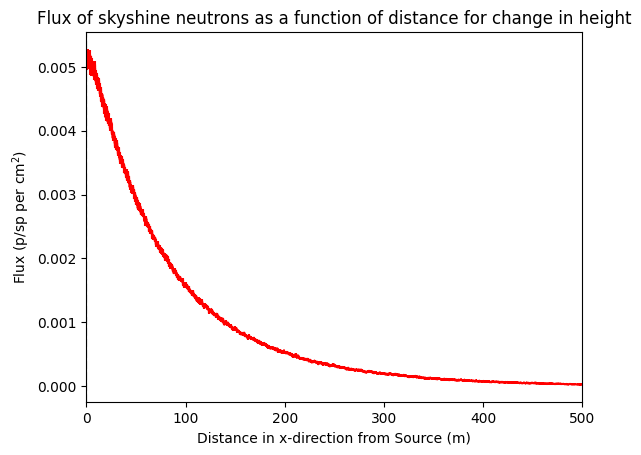

<Figure size 640x480 with 0 Axes>

In [69]:

flux = df[df['score'] == 'flux']
flux_mean = flux["mean"] / mesh_vol
flux_std = flux["std. dev."] / mesh_vol

plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'cyan', 'black', 'purple','m','olive', 'pink', 'lime', 'navy', 'turquoise' ]))) 
plt.errorbar(distance_x[:-1]/100, flux_mean, flux_std)
plt.xlabel("Distance in x-direction from Source (m)")
plt.ylabel("Flux (p/sp per cm$^2$)")
plt.axvline(x=0, ls='--', color='black')
plt.xlim(0, 500)
#plt.xscale('log')
#plt.yscale('log')
plt.title("Flux of skyshine neutrons as a function of distance for change in height")
   
plt.show()
plt.savefig("flux_dist.png")

In [62]:
max_stds

NameError: name 'max_stds' is not defined

In [70]:
plt.errorbar(source_height/100, max_means, yerr=max_stds, color='b', ls=None, marker='x')
plt.xlabel("Height (m)")
plt.ylabel("Flux p/sp per cm$^2$")
plt.title("Flux as a function of change in height of source")
#plt.ylim(0.0001, 0.5)
plt.xscale('log')
plt.yscale('log')

source_height

NameError: name 'source_height' is not defined

In [ ]:
flux_std/flux_mean

In [ ]:
plt.plot(distance_x[:-1]/100, (flux_std/flux_mean)*100, ls='--', marker='x')